<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/cnn_amber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.layers import Dense, Dropout
from keras.layers import Flatten

In [3]:
img_rows = 50
img_cols = 50
epochs = 200
batch_size = 250
num_of_train_samples = 1265
num_of_test_samples = 405
num_of_val_samples = 200

In [4]:
#part2-fitting the cnn to the images
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True)

In [5]:
# Generating images for the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)
# Creating training set
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Amber_yolo/train',
                                                 target_size = (img_rows, img_cols),
                                                 batch_size = batch_size,
                                                 shuffle = True,
                                                 class_mode = 'sparse')
# Creating the Test set
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Amber_yolo/test',
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            class_mode = 'sparse')

# Creating the Test set
valid_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Amber_yolo/val',
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            class_mode = 'sparse')

Found 1265 images belonging to 20 classes.
Found 504 images belonging to 20 classes.
Found 200 images belonging to 20 classes.


In [6]:
# Making Sppnet custom layer
# Try refering github implementation
# Refer https://keras.io/layers/writing-your-own-keras-layers/
# or https://keras.io/examples/antirectifier/
import sys
from keras.layers import Layer
from keras import backend as K

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

BATCH = 20

class SppnetLayer(Layer):
    '''This layer takes an input tensor and pools the tensor
      in local spatial bins.
      This layer uses Max pooling.
      It accepts input in tensorflow format. # channels last

    # Input
        list of filter in form [x,y,z] 
    # Input shape : 4d tensor [None, X,Y, channels]
    # Output shape : 3d tensor [None,pooled dim, channels] 

    '''
    def __init__(self, filters = [1], **kwargs):
        self.filters = filters
        super(SppnetLayer, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        length = 0;
        for f_size in self.filters:
            length+= (f_size*f_size)
        return (input_shape[0],length*input_shape[3])
      
    def get_config(self):
        config = {'filters': self.filters}
        base_config = super(SppnetLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
      output = []
      for f_size in self.filters:
        win_size = K.int_shape(inputs)[1]/f_size
        #print(win_size)
        win_size = int(win_size)
        for x_start in range(0,f_size):
          for y_start in range(0,f_size):
            X = int(x_start*win_size)
            Y = int(y_start*win_size)
            result = K.max(inputs[:,X:X+win_size,Y:Y+win_size,:],axis = (1,2))
            output.append(result)
      output = K.concatenate(output)
      return output

In [7]:
model=Sequential()

model.add(Conv2D(8,(5,5),activation='relu',input_shape=(img_rows,img_cols,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

model.add(Conv2D(16,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Dropout(0.15))

#model.add(SppnetLayer([1,2,4])) #To implement SppNet 
model.add(Flatten())
model.add(Dense(160,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(20,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 8)         608       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 16)       6

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.8,min_lr = 0.00001)
mcp_save = ModelCheckpoint('/content/drive/MyDrive/Amber_yolo/mdl_wts1.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
callbacks = [mcp_save] #[earlystop,learning_rate_reduction]

In [9]:
history = model.fit_generator(training_set,epochs=epochs, validation_data=test_set,callbacks=callbacks)

<ipython-input-9-ca9538c2e710>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(training_set,epochs=epochs, validation_data=test_set,callbacks=callbacks)


Epoch 1/200
6/6 [==============================] - 327s 65s/step - loss: 2.9455 - accuracy: 0.1581 - val_loss: 2.9698 - val_accuracy: 0.0615
Epoch 2/200
6/6 [==============================] - 9s 2s/step - loss: 2.1957 - accuracy: 0.3012 - val_loss: 2.9703 - val_accuracy: 0.0873
Epoch 3/200
6/6 [==============================] - 10s 2s/step - loss: 2.0142 - accuracy: 0.3455 - val_loss: 2.9745 - val_accuracy: 0.0893
Epoch 4/200
6/6 [==============================] - 10s 2s/step - loss: 1.7767 - accuracy: 0.3929 - val_loss: 3.0017 - val_accuracy: 0.0913
Epoch 5/200
6/6 [==============================] - 9s 2s/step - loss: 1.6819 - accuracy: 0.4174 - val_loss: 3.0412 - val_accuracy: 0.0893
Epoch 6/200
6/6 [==============================] - 9s 2s/step - loss: 1.5931 - accuracy: 0.4356 - val_loss: 3.1020 - val_accuracy: 0.0675
Epoch 7/200
6/6 [==============================] - 11s 2s/step - loss: 1.5011 - accuracy: 0.4609 - val_loss: 3.1504 - val_accuracy: 0.0813
Epoch 8/200
6/6 [===========

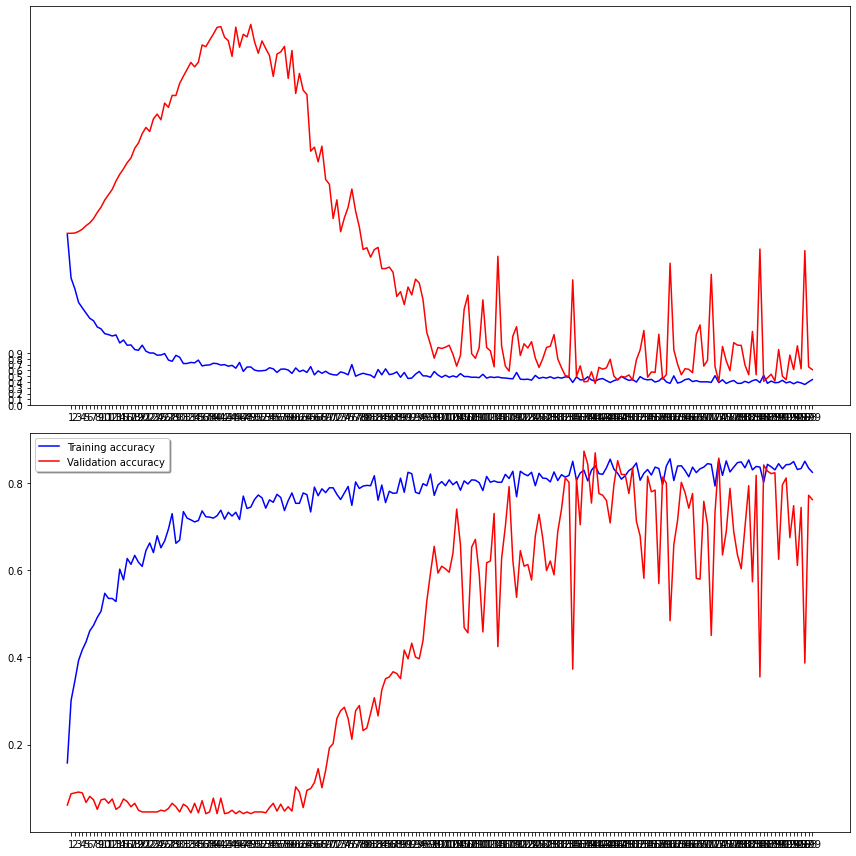

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [27]:
#AlexNet Inmplementation with batch normalization layers
model1 = Sequential()
model1.add(Conv2D(filters=96, input_shape=(img_rows,img_cols,3), kernel_size=(11,11), strides=(4,4), padding='same',activation = 'relu'))
model1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same',activation = 'relu'))
model1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same',activation = 'relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same',activation = 'relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same',activation = 'relu'))
model1.add(BatchNormalization())
model1.add(Flatten()) # To implement Simple Alexnet

model1.add(Dense(196,activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(196,activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(20,activation= 'softmax'))
model1.compile(loss='sparse_categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 13, 13, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 96)         0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 6, 6, 96)         384       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 256)         614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 256)        0         
 2D)                                                             
                                                      

In [12]:
mcp_save = ModelCheckpoint('/content/drive/MyDrive/Amber_yolo/mdl_wts2.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
callbacks = [mcp_save] #[earlystop,learning_rate_reduction]
history1 = model1.fit_generator(training_set,epochs=epochs, validation_data=test_set,callbacks=callbacks)

<ipython-input-12-8aae5ec20605>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model1.fit_generator(training_set,epochs=epochs, validation_data=test_set,callbacks=callbacks)


Epoch 1/200
6/6 [==============================] - 31s 5s/step - loss: 3.3636 - accuracy: 0.1217 - val_loss: 5.3533 - val_accuracy: 0.0516
Epoch 2/200
6/6 [==============================] - 28s 5s/step - loss: 2.7039 - accuracy: 0.2482 - val_loss: 5.7505 - val_accuracy: 0.0635
Epoch 3/200
6/6 [==============================] - 28s 5s/step - loss: 2.2533 - accuracy: 0.2925 - val_loss: 5.6049 - val_accuracy: 0.0635
Epoch 4/200
6/6 [==============================] - 29s 5s/step - loss: 2.0682 - accuracy: 0.3478 - val_loss: 5.1958 - val_accuracy: 0.0635
Epoch 5/200
6/6 [==============================] - 31s 5s/step - loss: 1.8805 - accuracy: 0.3818 - val_loss: 7.7574 - val_accuracy: 0.0635
Epoch 6/200
6/6 [==============================] - 29s 4s/step - loss: 1.5428 - accuracy: 0.4498 - val_loss: 11.1291 - val_accuracy: 0.0635
Epoch 7/200
6/6 [==============================] - 29s 5s/step - loss: 2.3538 - accuracy: 0.2704 - val_loss: 10.9194 - val_accuracy: 0.0635
Epoch 8/200
6/6 [========

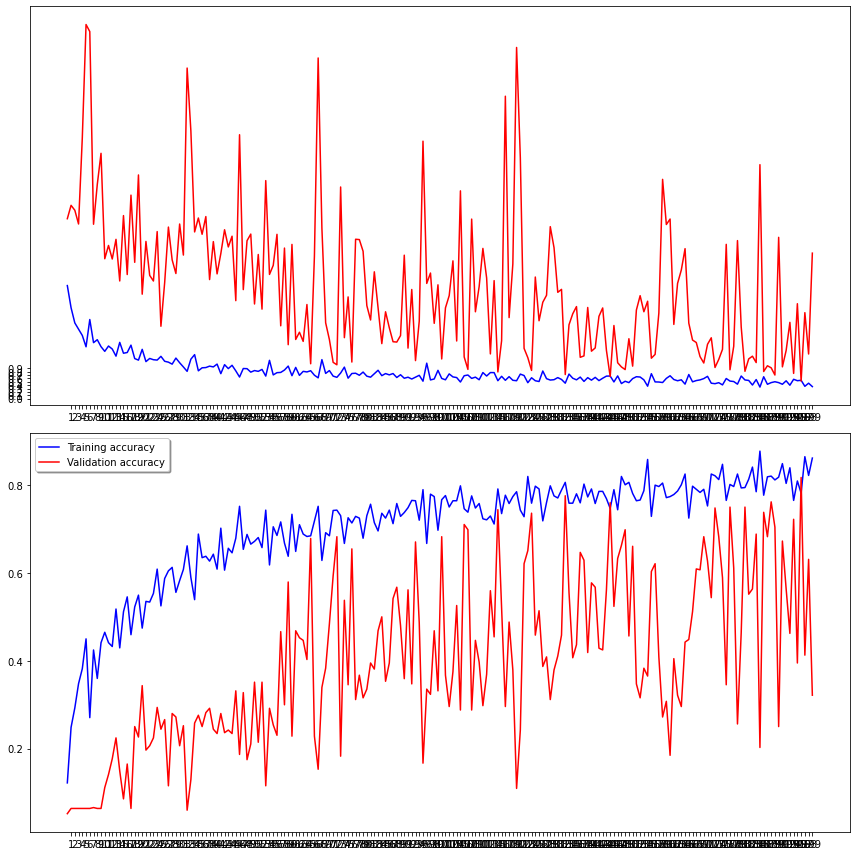

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history1.history['loss'], color='b', label="Training loss")
ax1.plot(history1.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history1.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history1.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [14]:
model.save("/content/drive/MyDrive/Amber_yolo/model1_amber150epoch.h5")

In [24]:
model.load_weights('/content/drive/MyDrive/Amber_yolo/mdl_wts1.hdf5')
y_pred = model.predict_generator(test_set)

<ipython-input-24-7a250e4b5ce2>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_set)


In [22]:
test_set.classes

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = ['N01', 'N02', 'N03','N04','N05','N06','N07','N08','N09','N10','N11','N12','N13','N14','N15','N16','N17','N18','N19','N20']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Confusion Matrix
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 1 0 1 2 3 6 5 1 0 0 0 2 3 0 1 2 0 1 0]
 [2 3 3 5 0 0 1 3 1 2 2 1 1 3 1 1 2 1 0 2 0]
 [3 3 1 1 1 4 0 2 1 1 1 1 0 1 3 3 1 1 1 3 0]
 [0 4 1 1 2 2 0 0 0 2 1 0 2 3 0 1 3 1 2 2 0]
 [0 1 2 1 2 3 2 0 2 0 2 1 2 3 3 3 1 0 1 1 0]
 [1 2 0 1 1 6 0 2 1 0 2 1 2 1 2 0 1 1 2 2 0]
 [2 1 5 1 2 1 0 3 2 3 0 1 2 2 0 0 3 0 0 1 0]
 [1 2 3 0 1 2 0 2 2 0 1 2 1 2 2 2 1 2 0 0 0]
 [0 0 0 2 5 1 3 2 4 1 1 1 2 1 0 0 1 0 0 2 0]
 [1 1 1 1 2 0 2 0 0 0 0 0 1 1 0 1 2 0 2 0 0]
 [1 1 0 1 0 2 1 1 0 2 1 1 0 2 0 0 0 1 1 0 0]
 [0 2 2 0 1 2 0 1 0 0 0 0 0 0 2 0 2 1 1 0 0]
 [1 0 1 0 1 0 1 0 1 0 0 0 0 3 1 0 0 1 1 3 0]
 [0 1 1 3 3 3 7 2 4 1 0 1 1 3 2 3 4 1 4 0 0]
 [2 3 1 1 0 2 1 1 1 0 1 2 0 1 1 2 1 1 0 2 0]
 [2 3 0 1 0 1 0 1 0 0 1 2 1 3 2 1 0 0 3 0 0]
 [1 1 1 2 1 1 2 1 0 3 0 0 0 6 1 1 1 0 0 1 0]
 [2 2 2 2 1 0 3 0 0 1 1 1 0 1 1 0 0 3 3 1 0]
 [5 0 0 2 1 0 1 3 2 0 2 0 0 4 0 0 1 0 1 1 0]
 [2 2 2 1 1 2 1 0 1 0 2 1 1 0 1 2 0 1 1 3 0]]
Classification Report
              p

In [28]:
model1.load_weights('/content/drive/MyDrive/Amber_yolo/mdl_wts2.hdf5')
y_pred = model1.predict_generator(test_set)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = ['N01', 'N02', 'N03','N04','N05','N06','N07','N08','N09','N10','N11','N12','N13','N14','N15','N16','N17','N18','N19','N20']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

<ipython-input-28-f586cdba5e2a>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model1.predict_generator(test_set)


Confusion Matrix
[[3 2 2 0 3 4 1 1 1 0 1 1 0 2 3 0 3 2 1 2]
 [4 1 4 5 2 2 3 1 0 0 2 0 0 3 1 0 4 0 1 1]
 [2 5 0 3 1 1 0 1 0 0 2 0 2 4 3 1 4 2 1 0]
 [1 2 3 1 1 3 0 2 0 1 3 1 0 0 2 1 0 2 2 2]
 [5 0 1 0 1 1 5 1 0 1 0 0 1 2 4 1 1 1 5 0]
 [2 0 1 2 1 3 1 1 0 0 1 0 2 5 1 0 0 5 2 1]
 [3 2 3 1 2 4 0 1 2 2 4 0 0 2 1 0 1 0 0 1]
 [3 1 0 0 0 1 6 2 1 0 1 0 0 0 3 0 6 0 1 1]
 [4 1 3 1 0 1 1 5 1 2 0 0 1 2 1 0 1 0 2 0]
 [3 1 0 0 1 0 1 1 1 0 0 2 0 0 1 0 2 1 0 1]
 [2 2 2 0 0 2 0 0 0 1 0 0 1 1 1 2 1 0 0 0]
 [2 0 0 1 1 1 0 0 1 0 2 0 0 1 1 2 1 1 0 0]
 [0 0 0 1 0 4 2 1 0 0 0 1 0 0 0 0 0 1 2 2]
 [4 1 2 2 0 2 1 2 2 0 0 1 5 6 3 4 3 0 3 3]
 [2 0 1 2 3 2 1 0 1 1 0 0 0 4 0 0 2 2 1 1]
 [1 1 3 0 3 2 2 2 1 0 1 0 0 0 0 2 0 1 0 2]
 [0 1 2 2 0 1 0 0 1 0 1 0 2 3 1 2 3 1 0 3]
 [3 1 0 2 2 0 2 2 3 0 0 0 0 2 2 0 1 1 2 1]
 [1 2 0 0 2 0 3 0 1 0 0 1 1 2 3 1 3 0 1 2]
 [2 1 1 3 0 1 2 2 1 1 3 0 0 1 2 2 0 1 1 0]]
Classification Report
              precision    recall  f1-score   support

         N01       0.06      0.09      0.08  